In [1]:
import numpy as np
import pickle
import os, sys
import pathlib

import pandas as pd

import time
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import regularizers
from jax import random
import jax
import sklearn

dir_dir = '/Users/mxd6118/Desktop/DiffSim/'
#src_dir = os.path.dirname(dir_dir) + "/src/"
sys.path.insert(0,'/Users/mxd6118/Desktop/DiffSim')
from Plots import *

from src.simulator.NEW_Simulator_normal import simulate_waveforms, init_params


In [2]:
class Producer():

    def __init__(self):
        
        self.key = random.PRNGKey(int(time.time()))
        number_of_events = int(input('How many events to be produced?'))
        params_path = dir_dir + "/bin/output/8530/krypton/test_noise_constant_uniform/trained_params.pickle"
        params = self.load_state(params_path)
        
        
        self.dataloader  = self.build_dataloader(number_of_events)
        
        
        batch_real = next(self.dataloader.iterate())
        batch_real['Label'] = np.ones(len( batch_real['energy_deposits']))
        
        energy_depo = batch_real['energy_deposits']#self.build_random_batch(number_of_events)
        
        start = time.time()
        produced_pmt,produced_sipm = self.arrays(energy_depo,params)
        time_taken = time.time() - start
        
        batch_fake = {"energy_deposits": energy_depo,
                 "PMT_FAKE": np.array(produced_pmt),
                 "SIPM_FAKE": np.array(produced_sipm),
                 "Label_tempo": np.zeros(len(energy_depo))}
        
        self.data_set = batch_real | batch_fake
        
        #self.get_data(data_set,f'batch_produced_{number_of_events}')
        
        print(f'All done, time taken {time_taken} sec')

    def build_dataloader(self,number_of_events):

        from src.utils.dataloaders.krypton_DATES_CUSTOM_DROPOUT import krypton
        # Load the sipm database:
        sipm_db = pd.read_pickle("/Users/mxd6118/Desktop/DiffSim/database/new_sipm.pkl")
    
        dl = krypton(
            batch_size  = number_of_events,
            db          = sipm_db,
            path        = "/Users/mxd6118/Desktop/DiffSim/kdst",
            run         = 8530,
            shuffle = False,
            drop = 0,
            z_slice = 0,
            )
            
        return dl

    
    def arrays(self,monitor_data,params):
        
        self.key, subkey = jax.random.split(self.key)
        # First, run the monitor data through the simulator:
        simulated_pmts, simulated_sipms = simulate_waveforms(monitor_data, params, subkey)
        
        return simulated_pmts, simulated_sipms
        
    def load_state(self,file):
        with open(file,"rb") as f:
            params = pickle.load(f)
        return params
        
    def get_data(self, data, name_data):
        
        with open(f'{name_data}.pickle','wb') as f:
            pickle.dump(data, f)
            f.close()
        

    def build_random_batch(self, number_of_events):
    
        batch =[]
        for i in range(0,number_of_events):
            one = np.hstack((np.random.uniform(low = -150, high = 150),
                             np.random.uniform(low = -150, high = 150),
                             np.random.uniform(low = 20,   high = 500),0.0415575))

            two = np.vstack((one,np.zeros(4)))
    
            batch.append(two)

        return np.array(batch)

In [19]:
batch = Producer()


How many events to be produced?100
All done, time taken 22.174582958221436 sec


In [7]:
data = batch.data_set

In [8]:
data.keys()

dict_keys(['energy_deposits', 'S1Pmt', 'S2Si', 'S2Pmt', 'time', 'Label', 'PMT_FAKE', 'SIPM_FAKE', 'Label_tempo'])

In [9]:
len(data['energy_deposits'])

50

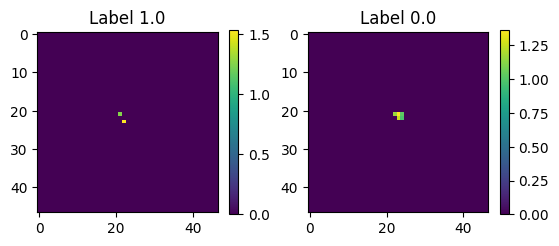

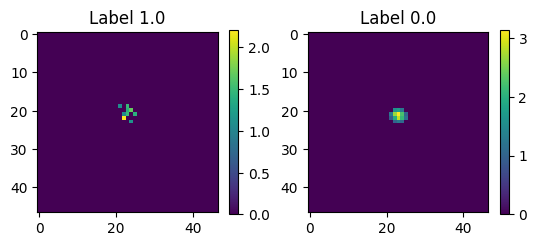

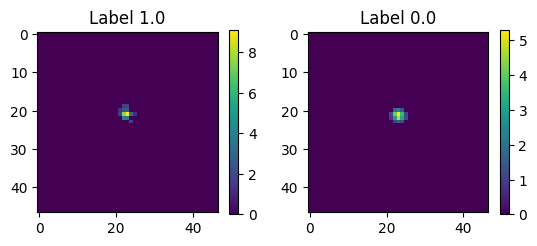

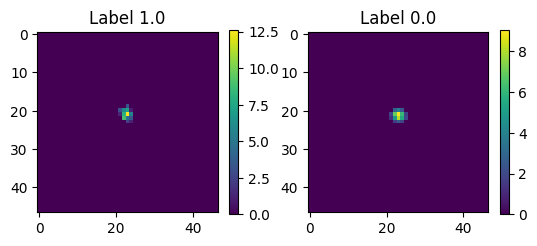

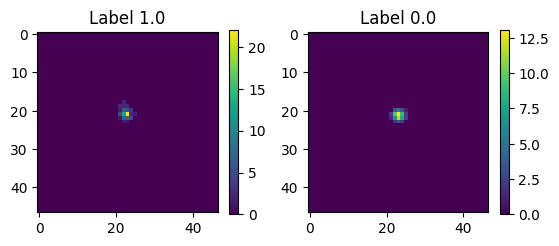

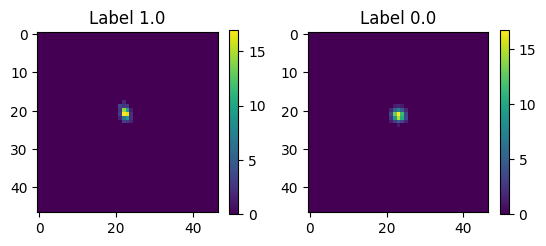

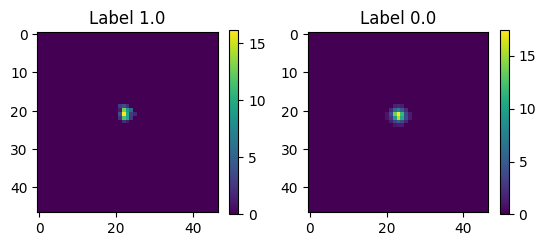

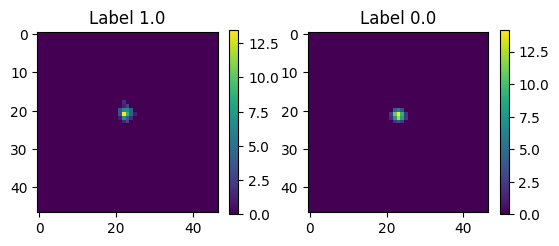

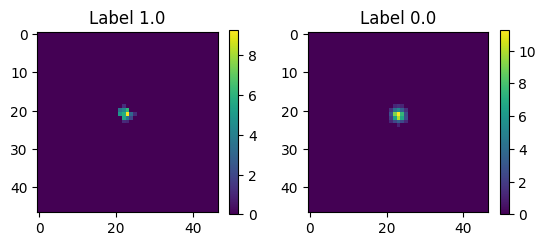

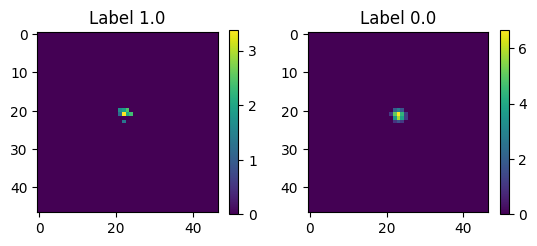

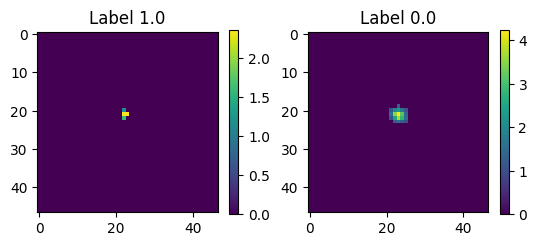

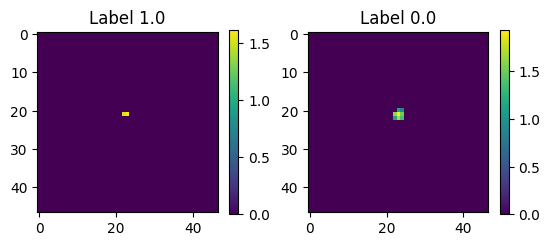

In [10]:
n = np.random.randint(0,len(data['energy_deposits']))

z = np.random.choice(np.unique(np.where(data['S2Si'][n] != 0)[2]))

for z in np.unique(np.where(data['S2Si'][n] != 0)[2]):

    #fig = plt.figure(figsize=(16,9))
    plt.subplot(1, 2, 1)
    plt.title(f'Label {(data["Label"][n])}')
    plt.imshow(data['S2Si'][n,:,:,z])

    plt.colorbar(shrink=0.5)

    plt.subplot(1, 2, 2)
    plt.title(f'Label {(data["Label_tempo"][n])}')
    plt.imshow(data['SIPM_FAKE'][n,:,:,z])
    plt.colorbar(shrink=0.5)

    plt.show()


In [11]:
train_batch_filtered = {}
train_batch_filtered['S2Si'] = []
train_batch_filtered['SIPM_FAKE'] =[]


for n in range(0,len(data['energy_deposits'])):
    for z in np.unique(np.where(data['S2Si'][n] != 0)[2]):

        train_batch_filtered['S2Si'].append(data['S2Si'][n,:,:,z])
        train_batch_filtered['SIPM_FAKE'].append(data['SIPM_FAKE'][n,:,:,z])
        

l = len(train_batch_filtered['S2Si'])

train_batch_filtered['train'] = np.vstack((train_batch_filtered['S2Si'],train_batch_filtered['SIPM_FAKE']))
train_batch_filtered['Labels'] = np.hstack((np.ones(l),np.zeros(l)))


train, labels = sklearn.utils.shuffle(train_batch_filtered['train'],train_batch_filtered['Labels'])


batch = {}
batch['Train'] = train 
batch['Labels'] = labels

In [12]:
print(len(batch['Labels']))

900


Epoch 1/200


2023-08-21 09:28:50.085155: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


29/29 [==============================] - 0s 962us/step - loss: 0.7013 - accuracy: 0.5089
Epoch 2/200
29/29 [==============================] - 0s 1ms/step - loss: 0.6205 - accuracy: 0.7000
Epoch 3/200
29/29 [==============================] - 0s 1ms/step - loss: 0.4584 - accuracy: 0.8211
Epoch 4/200
29/29 [==============================] - 0s 1ms/step - loss: 0.3200 - accuracy: 0.8844
Epoch 5/200
29/29 [==============================] - 0s 1ms/step - loss: 0.2179 - accuracy: 0.9244
Epoch 6/200
29/29 [==============================] - 0s 1ms/step - loss: 0.1577 - accuracy: 0.9522
Epoch 7/200
29/29 [==============================] - 0s 1ms/step - loss: 0.1225 - accuracy: 0.9556
Epoch 8/200
29/29 [==============================] - 0s 1ms/step - loss: 0.1025 - accuracy: 0.9600
Epoch 9/200
29/29 [==============================] - 0s 1ms/step - loss: 0.0883 - accuracy: 0.9689
Epoch 10/200
29/29 [==============================] - 0s 1ms/step - loss: 0.0887 - accuracy: 0.9667
Epoch 11/200
29/29 

29/29 [==============================] - 0s 1ms/step - loss: 5.7557e-04 - accuracy: 1.0000
Epoch 83/200
29/29 [==============================] - 0s 1ms/step - loss: 5.2027e-04 - accuracy: 1.0000
Epoch 84/200
29/29 [==============================] - 0s 1ms/step - loss: 5.2420e-04 - accuracy: 1.0000
Epoch 85/200
29/29 [==============================] - 0s 1ms/step - loss: 4.8179e-04 - accuracy: 1.0000
Epoch 86/200
29/29 [==============================] - 0s 1ms/step - loss: 4.7285e-04 - accuracy: 1.0000
Epoch 87/200
29/29 [==============================] - 0s 1ms/step - loss: 4.6165e-04 - accuracy: 1.0000
Epoch 88/200
29/29 [==============================] - 0s 1ms/step - loss: 4.3237e-04 - accuracy: 1.0000
Epoch 89/200
29/29 [==============================] - 0s 1ms/step - loss: 4.3443e-04 - accuracy: 1.0000
Epoch 90/200
29/29 [==============================] - 0s 1ms/step - loss: 4.0265e-04 - accuracy: 1.0000
Epoch 91/200
29/29 [==============================] - 0s 1ms/step - loss: 3.9

29/29 [==============================] - 0s 1ms/step - loss: 3.6305e-05 - accuracy: 1.0000
Epoch 161/200
29/29 [==============================] - 0s 1ms/step - loss: 3.4947e-05 - accuracy: 1.0000
Epoch 162/200
29/29 [==============================] - 0s 1ms/step - loss: 3.4009e-05 - accuracy: 1.0000
Epoch 163/200
29/29 [==============================] - 0s 1ms/step - loss: 3.2680e-05 - accuracy: 1.0000
Epoch 164/200
29/29 [==============================] - 0s 1ms/step - loss: 3.2010e-05 - accuracy: 1.0000
Epoch 165/200
29/29 [==============================] - 0s 1ms/step - loss: 3.1352e-05 - accuracy: 1.0000
Epoch 166/200
29/29 [==============================] - 0s 1ms/step - loss: 3.0589e-05 - accuracy: 1.0000
Epoch 167/200
29/29 [==============================] - 0s 1ms/step - loss: 2.9468e-05 - accuracy: 1.0000
Epoch 168/200
29/29 [==============================] - 0s 1ms/step - loss: 2.8344e-05 - accuracy: 1.0000
Epoch 169/200
29/29 [==============================] - 0s 1ms/step - 

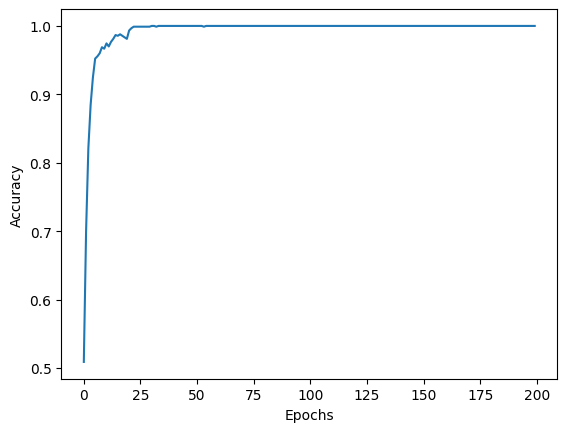

In [13]:
Adam = None

Adam = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(47,47)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(12, activation='sigmoid'),
    tf.keras.layers.Dense(2,activation='sigmoid'),
    ])

opt = keras.optimizers.Adamax(learning_rate=0.01)

Adam.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = Adam.fit(train,labels, epochs=200)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')

In [14]:
#for n in range(0,len(train)):

    #print(f'Pred: {np.argmax(Adam(train),axis = 1)[n]}, real {labels[n]}')
    
np.count_nonzero(np.argmax(Adam(train),axis = 1) - labels)

0

In [18]:
[print(pred) for pred in np.array(Adam(train))]

[9.9555808e-01 6.0896995e-04]
[0.00421483 0.9983511 ]
[9.9555534e-01 6.0944265e-04]
[0.00421806 0.99834955]
[0.00427024 0.9983242 ]
[9.9555904e-01 6.0880231e-04]
[9.955590e-01 6.088136e-04]
[9.949513e-01 7.151572e-04]
[9.941238e-01 8.671085e-04]
[0.00421924 0.99834895]
[0.00421509 0.998351  ]
[0.00423863 0.99833953]
[9.9556053e-01 6.0854584e-04]
[0.00421291 0.99835205]
[9.9550813e-01 6.1750429e-04]
[0.004213 0.998352]
[0.00421482 0.9983511 ]
[9.9542046e-01 6.3264411e-04]
[9.9551094e-01 6.1703479e-04]
[9.9555892e-01 6.0882606e-04]
[0.00789396 0.99637496]
[9.955580e-01 6.089824e-04]
[9.9556017e-01 6.0860679e-04]
[9.955604e-01 6.085743e-04]
[9.9533904e-01 6.4695970e-04]
[9.955480e-01 6.106901e-04]
[9.9556047e-01 6.0855545e-04]
[9.9555755e-01 6.0906203e-04]
[9.9534798e-01 6.4506213e-04]
[0.00421485 0.9983511 ]
[0.00422023 0.9983485 ]
[0.00421296 0.99835205]
[9.954182e-01 6.331785e-04]
[0.00484689 0.9980372 ]
[0.00421431 0.9983514 ]
[9.9556035e-01 6.0858100e-04]
[0.00448473 0.9982186 ]
[0.0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,